In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

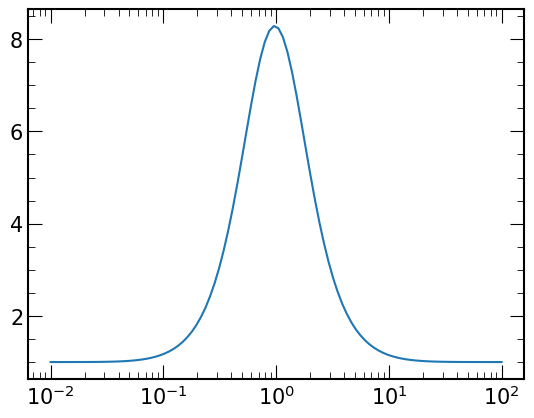

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-cda36a44f942>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
10.409628629684448
1.9 0.1
finished until t = 0.0 1.1120765209197998


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 6.104867935180664
finished until t = 1.0 14.602991342544556
finished until t = 1.5 26.029033422470093
finished until t = 2.0 39.706411361694336
finished until t = 2.5 55.65156173706055
finished until t = 3.0 72.97871470451355
finished until t = 3.5 91.88488864898682
finished until t = 4.0 112.23533821105957
finished until t = 4.5 134.5123679637909
finished until t = 5.0 161.67142820358276
finished until t = 5.5 190.07521295547485
finished until t = 6.0 219.96255564689636
finished until t = 6.5 251.36860537528992
finished until t = 7.0 284.5802435874939
finished until t = 7.5 319.288046836853
finished until t = 8.0 355.55244731903076
finished until t = 8.5 393.1731216907501
finished until t = 9.0 432.2107102870941
finished until t = 9.5 472.9647743701935
finished until t = 10.0 514.9170229434967


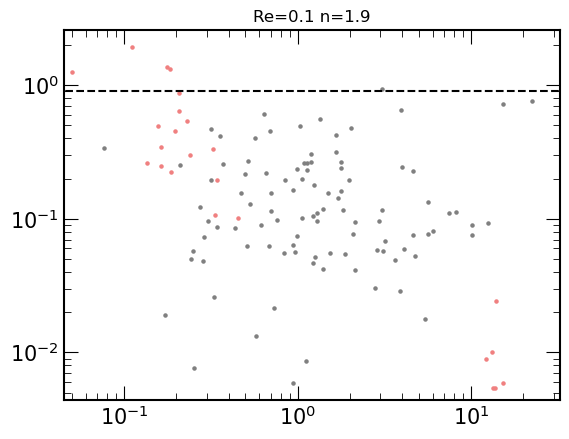

Calculating NFW Energies and Weights


<ipython-input-3-cda36a44f942>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
10.309787273406982
1.9 0.3
finished until t = 0.0 0.6525869369506836
finished until t = 0.5 5.757585763931274
finished until t = 1.0 15.881556987762451
finished until t = 1.5 30.188005924224854
finished until t = 2.0 48.50010585784912
finished until t = 2.5 71.05929851531982
finished until t = 3.0 96.89470219612122
finished until t = 3.5 126.76217532157898
finished until t = 4.0 159.91061997413635
finished until t = 4.5 195.9997546672821
finished until t = 5.0 234.8946943283081
finished until t = 5.5 276.8840854167938
finished until t = 6.0 321.283490896225
finished until t = 6.5 368.39111375808716
finished until t = 7.0 418.26559686660767
finished until t = 7.5 470.2772626876831
finished until t = 8.0 524.9603695869446
finished until t = 8.5 582.0894215106964
finished until t = 9.0 641.5470325946808
finished until t = 9.5 702.8686120510101
finished until t = 10.0 766.8916618824005


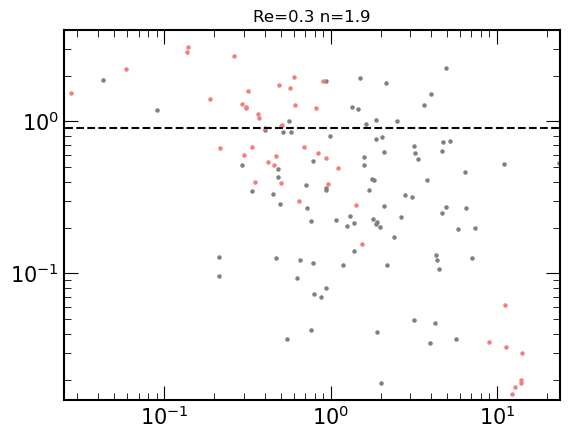

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.564013957977295
1.9 0.5
finished until t = 0.0 0.6324265003204346
finished until t = 0.5 5.41495680809021
finished until t = 1.0 13.923816204071045
finished until t = 1.5 26.7580087184906
finished until t = 2.0 44.10473990440369
finished until t = 2.5 64.64834547042847
finished until t = 3.0 89.51967215538025
finished until t = 3.5 118.19604015350342
finished until t = 4.0 150.4384765625
finished until t = 4.5 186.81604051589966
finished until t = 5.0 227.09568858146667
finished until t = 5.5 271.0410692691803
finished until t = 6.0 319.4381983280182
finished until t = 6.5 371.49841046333313
finished until t = 7.0 427.93935108184814
finished until t = 7.5 486.80172634124756
finished until t = 8.0 548.8386073112488
finished until t = 8.5 614.0529119968414
finished until t = 9.0 683.1359596252441
finished until t = 9.5 754.6198749542236
finished until t = 10.0 828.7704746723175


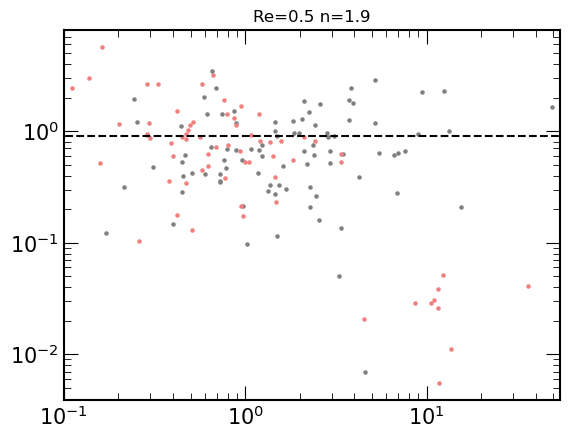

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.585424423217773
1.9 0.7
finished until t = 0.0 0.6810398101806641
finished until t = 0.5 5.848296403884888
finished until t = 1.0 16.004310846328735
finished until t = 1.5 30.48369860649109
finished until t = 2.0 50.09140419960022
finished until t = 2.5 75.0859477519989
finished until t = 3.0 104.53657245635986
finished until t = 3.5 139.32394981384277
finished until t = 4.0 178.98809099197388
finished until t = 4.5 221.63855981826782
finished until t = 5.0 269.68727827072144
finished until t = 5.5 321.6861820220947
finished until t = 6.0 378.40629720687866
finished until t = 6.5 439.13837599754333
finished until t = 7.0 502.88894605636597
finished until t = 7.5 573.4219036102295
finished until t = 8.0 646.1422200202942
finished until t = 8.5 722.8887329101562
finished until t = 9.0 803.8481848239899
finished until t = 9.5 889.7976853847504
finished until t = 10.0 979.7861595153809


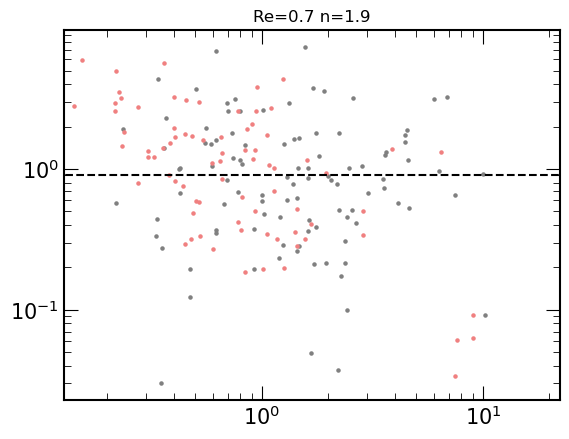

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.99645209312439
1.9 0.9
finished until t = 0.0 0.7087657451629639
finished until t = 0.5 6.128021240234375
finished until t = 1.0 17.188535690307617
finished until t = 1.5 33.54670524597168
finished until t = 2.0 54.4131133556366
finished until t = 2.5 80.85902523994446
finished until t = 3.0 112.24318289756775
finished until t = 3.5 149.58846831321716
finished until t = 4.0 190.43964648246765
finished until t = 4.5 236.108558177948
finished until t = 5.0 286.85796093940735
finished until t = 5.5 342.40870094299316
finished until t = 6.0 403.4448187351227
finished until t = 6.5 469.75158643722534
finished until t = 7.0 540.3324456214905
finished until t = 7.5 616.2448408603668
finished until t = 8.0 697.0616500377655
finished until t = 8.5 782.9599704742432
finished until t = 9.0 873.8075175285339
finished until t = 9.5 968.6483268737793
finished until t = 10.0 1069.9871563911438


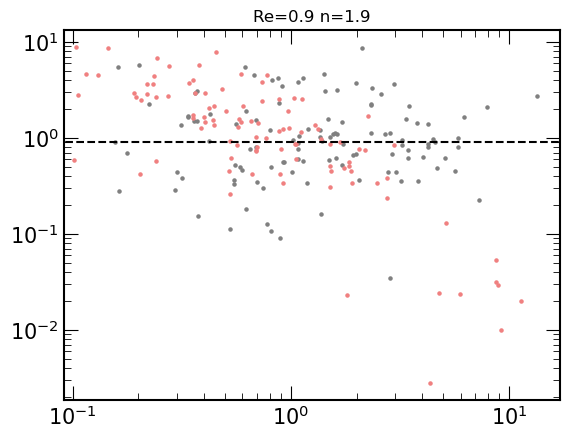

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.428795337677002
1.9 1.1
finished until t = 0.0 0.5887706279754639
finished until t = 0.5 4.2424139976501465
finished until t = 1.0 11.08613634109497
finished until t = 1.5 21.140815019607544
finished until t = 2.0 34.47256135940552
finished until t = 2.5 51.09488773345947
finished until t = 3.0 71.19395232200623
finished until t = 3.5 94.73870873451233
finished until t = 4.0 122.62781047821045
finished until t = 4.5 154.23977494239807
finished until t = 5.0 188.89787793159485
finished until t = 5.5 226.49362540245056
finished until t = 6.0 270.98849630355835
finished until t = 6.5 316.62346029281616
finished until t = 7.0 364.93174982070923
finished until t = 7.5 416.52071952819824
finished until t = 8.0 472.9277505874634
finished until t = 8.5 532.8372738361359
finished until t = 9.0 594.6796224117279
finished until t = 9.5 660.1067607402802
finished until t = 10.0 729.1069462299347


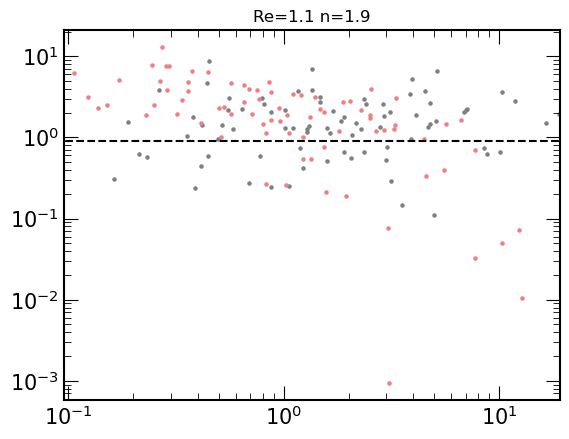

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.541293621063232
1.9 1.3
finished until t = 0.0 0.609614372253418
finished until t = 0.5 4.3183913230896
finished until t = 1.0 11.194184064865112
finished until t = 1.5 21.28217077255249
finished until t = 2.0 34.78874182701111
finished until t = 2.5 51.6407573223114
finished until t = 3.0 71.8513731956482
finished until t = 3.5 95.49445629119873
finished until t = 4.0 122.44458985328674
finished until t = 4.5 152.71778869628906
finished until t = 5.0 186.3982253074646
finished until t = 5.5 223.35209345817566
finished until t = 6.0 263.7174541950226
finished until t = 6.5 307.4511184692383
finished until t = 7.0 354.7512104511261
finished until t = 7.5 405.65032267570496
finished until t = 8.0 460.1422755718231
finished until t = 8.5 518.2909941673279
finished until t = 9.0 580.0296022891998
finished until t = 9.5 645.4365663528442
finished until t = 10.0 715.3028328418732


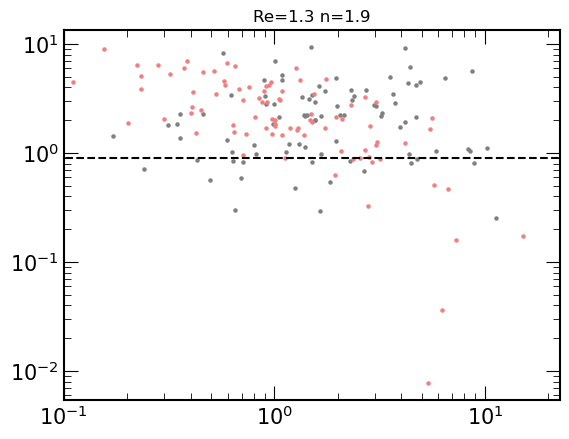

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.255995512008667
1.9 1.5
finished until t = 0.0 0.6166069507598877
finished until t = 0.5 4.790413856506348
finished until t = 1.0 12.62684440612793
finished until t = 1.5 24.607674837112427
finished until t = 2.0 40.641483306884766
finished until t = 2.5 60.13043284416199
finished until t = 3.0 83.53395366668701
finished until t = 3.5 110.90680837631226
finished until t = 4.0 142.1749267578125
finished until t = 4.5 177.33601760864258
finished until t = 5.0 216.53179240226746
finished until t = 5.5 259.78253269195557
finished until t = 6.0 306.79237937927246
finished until t = 6.5 357.93801403045654
finished until t = 7.0 412.68987822532654
finished until t = 7.5 471.3299779891968
finished until t = 8.0 533.9782383441925
finished until t = 8.5 600.5791616439819
finished until t = 9.0 671.0969834327698
finished until t = 9.5 745.545702457428
finished until t = 10.0 824.343368768692


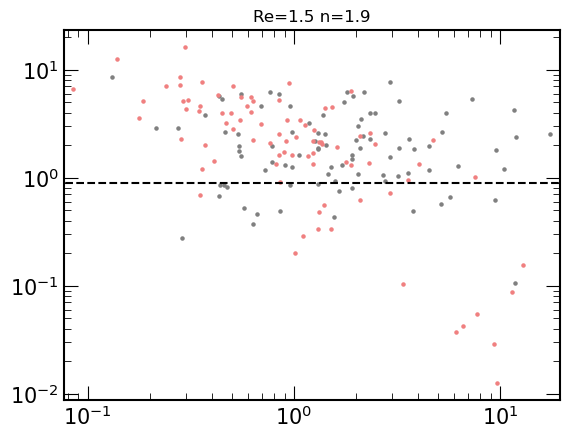

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.627016544342041
1.9 1.7
finished until t = 0.0 0.597571849822998
finished until t = 0.5 4.283303737640381
finished until t = 1.0 11.20090389251709
finished until t = 1.5 21.370903730392456
finished until t = 2.0 34.63282036781311
finished until t = 2.5 50.50819444656372
finished until t = 3.0 68.166348695755
finished until t = 3.5 88.91787362098694
finished until t = 4.0 112.33205199241638
finished until t = 4.5 138.53056645393372
finished until t = 5.0 167.49750089645386
finished until t = 5.5 199.25785613059998
finished until t = 6.0 233.91946387290955
finished until t = 6.5 271.59707283973694
finished until t = 7.0 312.3710241317749
finished until t = 7.5 356.0637803077698
finished until t = 8.0 402.7276680469513
finished until t = 8.5 452.2636516094208
finished until t = 9.0 504.96078395843506
finished until t = 9.5 560.8800256252289
finished until t = 10.0 619.7371191978455


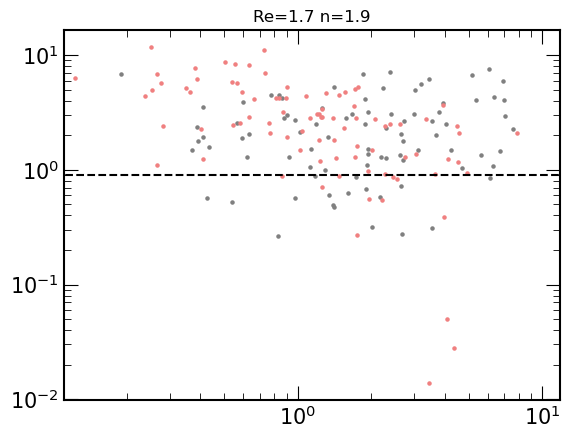

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.813410520553589
1.9 1.9
finished until t = 0.0 0.4657771587371826
finished until t = 0.5 3.107314109802246
finished until t = 1.0 8.110676527023315
finished until t = 1.5 15.208548069000244
finished until t = 2.0 24.49601411819458
finished until t = 2.5 35.91113495826721
finished until t = 3.0 49.61288022994995
finished until t = 3.5 65.60551500320435
finished until t = 4.0 83.89290761947632
finished until t = 4.5 104.91291999816895
finished until t = 5.0 127.76381492614746
finished until t = 5.5 152.79039549827576
finished until t = 6.0 180.06352162361145
finished until t = 6.5 209.64421033859253
finished until t = 7.0 241.60371732711792
finished until t = 7.5 275.67605328559875
finished until t = 8.0 312.10045766830444
finished until t = 8.5 350.6667196750641
finished until t = 9.0 391.2799150943756
finished until t = 9.5 434.28026008605957
finished until t = 10.0 479.6989345550537


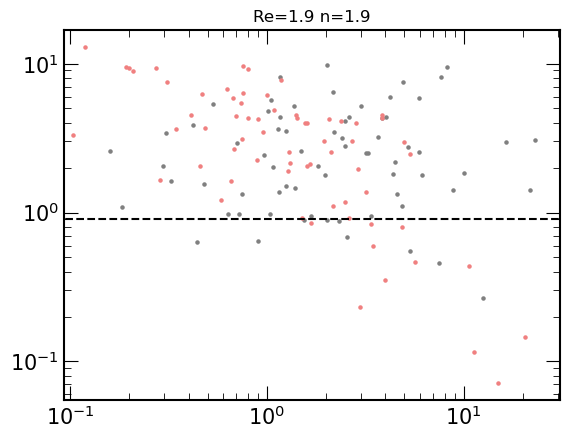

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.965853691101074
1.9 2.1
finished until t = 0.0 0.5049571990966797
finished until t = 0.5 3.6562271118164062
finished until t = 1.0 9.492196798324585
finished until t = 1.5 17.90191960334778
finished until t = 2.0 29.024760723114014
finished until t = 2.5 42.74594211578369
finished until t = 3.0 59.2093141078949
finished until t = 3.5 78.43454360961914
finished until t = 4.0 100.56964945793152
finished until t = 4.5 125.43605637550354
finished until t = 5.0 153.05760025978088
finished until t = 5.5 183.70833897590637
finished until t = 6.0 217.19228959083557
finished until t = 6.5 253.33677196502686
finished until t = 7.0 292.303480386734
finished until t = 7.5 333.94667530059814
finished until t = 8.0 378.01217126846313
finished until t = 8.5 425.64860582351685
finished until t = 9.0 476.15166878700256
finished until t = 9.5 529.8506667613983
finished until t = 10.0 586.6044435501099


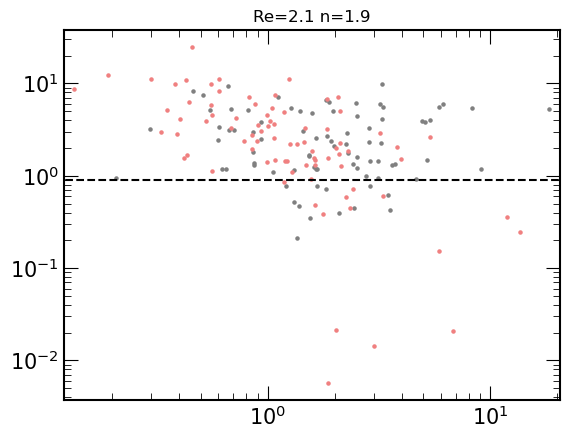

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.098967790603638
1.9 2.3
finished until t = 0.0 0.5242242813110352
finished until t = 0.5 3.6175882816314697
finished until t = 1.0 9.400898933410645
finished until t = 1.5 17.681345462799072
finished until t = 2.0 28.463234186172485
finished until t = 2.5 41.887364625930786
finished until t = 3.0 57.919955015182495
finished until t = 3.5 76.60002040863037
finished until t = 4.0 97.85826802253723
finished until t = 4.5 121.81231617927551
finished until t = 5.0 148.31673765182495
finished until t = 5.5 177.39742159843445
finished until t = 6.0 209.0738365650177
finished until t = 6.5 243.5478925704956
finished until t = 7.0 282.1564245223999
finished until t = 7.5 323.38750886917114
finished until t = 8.0 368.12667298316956
finished until t = 8.5 415.2693796157837
finished until t = 9.0 465.06914353370667
finished until t = 9.5 517.7340607643127
finished until t = 10.0 567.4550926685333


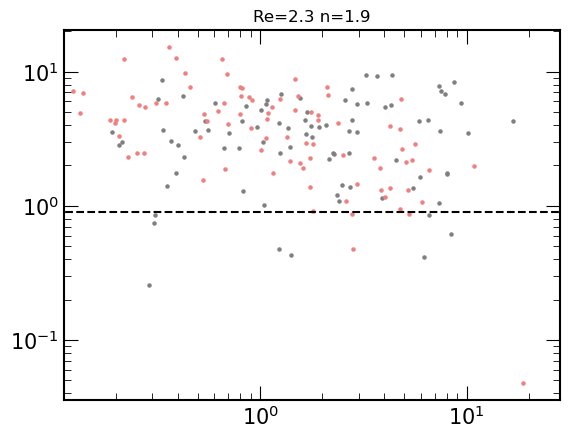

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.391403913497925
1.9 2.5
finished until t = 0.0 0.5118231773376465
finished until t = 0.5 3.571075677871704
finished until t = 1.0 8.773684740066528
finished until t = 1.5 16.998021841049194
finished until t = 2.0 27.16257882118225
finished until t = 2.5 40.41253089904785
finished until t = 3.0 56.27895259857178
finished until t = 3.5 74.30989074707031
finished until t = 4.0 94.92859292030334
finished until t = 4.5 118.28239822387695
finished until t = 5.0 144.03474879264832
finished until t = 5.5 172.14567375183105
finished until t = 6.0 202.7935676574707
finished until t = 6.5 236.39560341835022
finished until t = 7.0 273.70490074157715
finished until t = 7.5 313.3468608856201
finished until t = 8.0 354.8372926712036
finished until t = 8.5 398.15689873695374
finished until t = 9.0 444.6540496349335
finished until t = 9.5 493.7371497154236
finished until t = 10.0 545.3904492855072


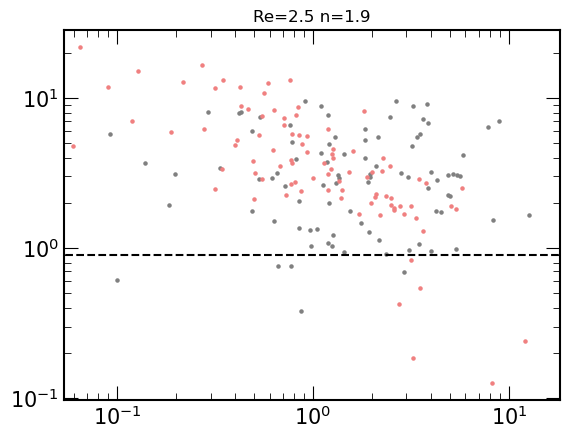

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.93572449684143
1.9 2.7
finished until t = 0.0 0.46860814094543457
finished until t = 0.5 3.425585985183716
finished until t = 1.0 9.18368411064148
finished until t = 1.5 17.334412813186646
finished until t = 2.0 28.211419343948364
finished until t = 2.5 41.408935546875
finished until t = 3.0 57.158830642700195
finished until t = 3.5 75.9502546787262
finished until t = 4.0 97.00345540046692
finished until t = 4.5 119.54576921463013
finished until t = 5.0 144.63653755187988
finished until t = 5.5 172.21807885169983
finished until t = 6.0 202.20533156394958
finished until t = 6.5 234.61814832687378
finished until t = 7.0 269.8169243335724
finished until t = 7.5 307.2974853515625
finished until t = 8.0 347.5119457244873
finished until t = 8.5 390.29290556907654
finished until t = 9.0 435.39192509651184
finished until t = 9.5 483.56423568725586
finished until t = 10.0 534.0954027175903


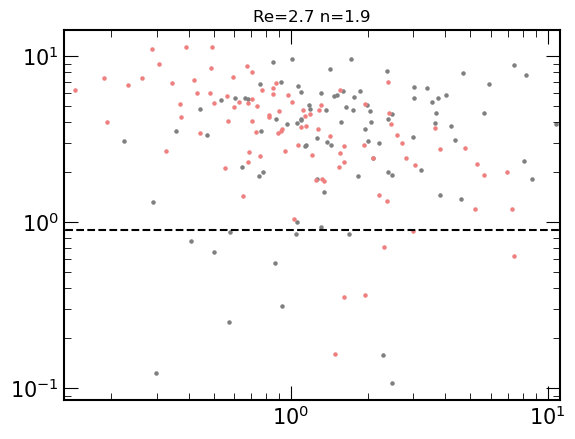

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.993705034255981
1.9 2.9
finished until t = 0.0 0.4427180290222168
finished until t = 0.5 3.083824396133423
finished until t = 1.0 8.032298803329468
finished until t = 1.5 15.188065767288208
finished until t = 2.0 24.583489656448364
finished until t = 2.5 36.13434672355652
finished until t = 3.0 49.964712381362915
finished until t = 3.5 66.06753945350647
finished until t = 4.0 84.49431943893433
finished until t = 4.5 105.28214979171753
finished until t = 5.0 128.1939787864685
finished until t = 5.5 153.44750809669495
finished until t = 6.0 181.02789449691772
finished until t = 6.5 210.87077927589417
finished until t = 7.0 243.1443634033203
finished until t = 7.5 277.77906250953674
finished until t = 8.0 314.78330731391907
finished until t = 8.5 354.072904586792
finished until t = 9.0 395.64512181282043
finished until t = 9.5 439.5265190601349
finished until t = 10.0 485.63904786109924


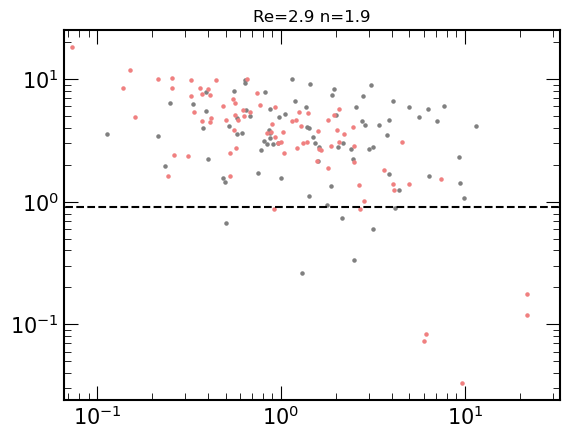

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.826771259307861
1.9 3.1
finished until t = 0.0 0.47056126594543457
finished until t = 0.5 3.419515609741211
finished until t = 1.0 8.714401960372925
finished until t = 1.5 16.557970762252808
finished until t = 2.0 26.888031721115112
finished until t = 2.5 39.744004249572754
finished until t = 3.0 54.876593351364136
finished until t = 3.5 72.41462922096252
finished until t = 4.0 92.3825159072876
finished until t = 4.5 114.6140251159668
finished until t = 5.0 139.32553100585938
finished until t = 5.5 166.60001683235168
finished until t = 6.0 196.18835401535034
finished until t = 6.5 228.35784006118774
finished until t = 7.0 263.19742941856384
finished until t = 7.5 300.5677990913391
finished until t = 8.0 340.73020339012146
finished until t = 8.5 383.0127010345459
finished until t = 9.0 428.2180886268616
finished until t = 9.5 475.7395963668823
finished until t = 10.0 525.9256136417389


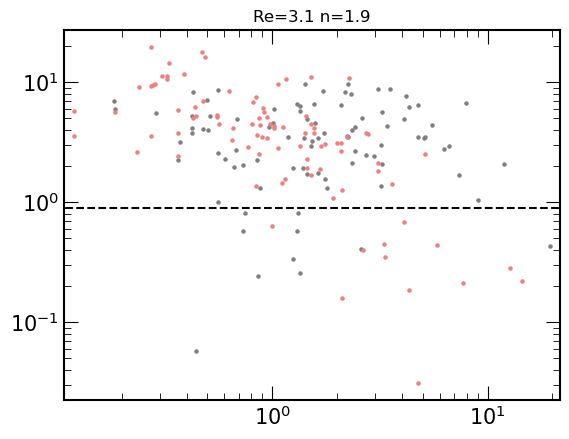

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.953447103500366
1.9 3.3
finished until t = 0.0 0.4770851135253906
finished until t = 0.5 3.351720094680786
finished until t = 1.0 8.697514295578003
finished until t = 1.5 16.735450267791748
finished until t = 2.0 26.79174280166626
finished until t = 2.5 40.04191064834595
finished until t = 3.0 55.716598987579346
finished until t = 3.5 74.0010118484497
finished until t = 4.0 95.06289029121399
finished until t = 4.5 118.42389488220215
finished until t = 5.0 144.22137236595154
finished until t = 5.5 172.47503519058228
finished until t = 6.0 203.4886908531189
finished until t = 6.5 237.18125891685486
finished until t = 7.0 273.34626030921936
finished until t = 7.5 312.03195548057556
finished until t = 8.0 353.47314620018005
finished until t = 8.5 397.36616230010986
finished until t = 9.0 443.59162950515747
finished until t = 9.5 492.586626291275
finished until t = 10.0 543.8744602203369


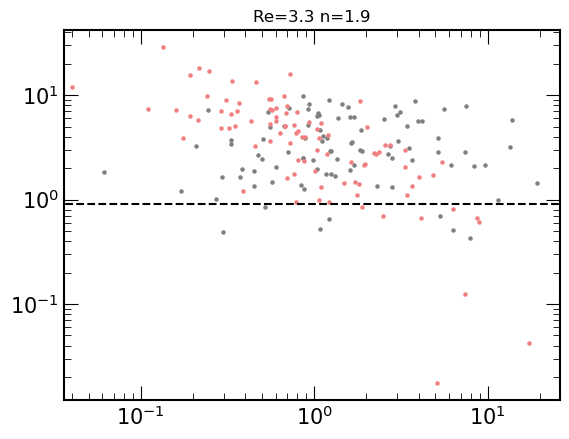

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.726203441619873
1.9 3.5
finished until t = 0.0 0.45578813552856445
finished until t = 0.5 3.042449474334717
finished until t = 1.0 7.732733249664307
finished until t = 1.5 14.878759384155273
finished until t = 2.0 24.112318754196167
finished until t = 2.5 35.903409481048584
finished until t = 3.0 49.95668339729309
finished until t = 3.5 66.39445114135742
finished until t = 4.0 85.13735151290894
finished until t = 4.5 106.44128966331482
finished until t = 5.0 130.1330211162567
finished until t = 5.5 155.72150540351868
finished until t = 6.0 183.95903182029724
finished until t = 6.5 214.45555710792542
finished until t = 7.0 247.35359382629395
finished until t = 7.5 282.55785942077637
finished until t = 8.0 320.5454044342041
finished until t = 8.5 360.4150125980377
finished until t = 9.0 402.8707423210144
finished until t = 9.5 447.6900472640991
finished until t = 10.0 494.8617308139801


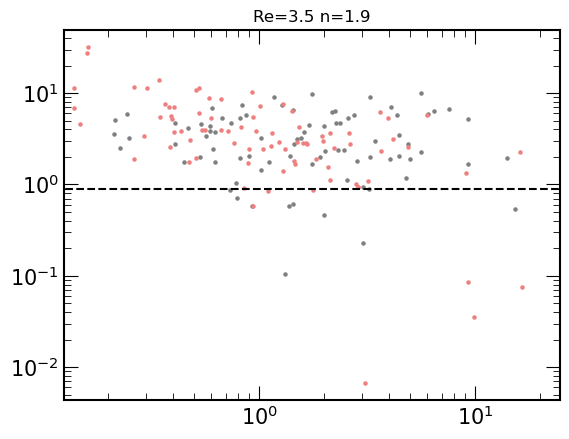

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.590404033660889
1.9 3.7
finished until t = 0.0 0.4180138111114502
finished until t = 0.5 2.9866342544555664
finished until t = 1.0 7.835960388183594
finished until t = 1.5 14.553748369216919
finished until t = 2.0 23.712658643722534
finished until t = 2.5 34.68761610984802
finished until t = 3.0 47.91783618927002
finished until t = 3.5 63.458617210388184
finished until t = 4.0 81.26008534431458
finished until t = 4.5 101.10950422286987
finished until t = 5.0 122.9235942363739
finished until t = 5.5 147.14433646202087
finished until t = 6.0 173.2592670917511
finished until t = 6.5 201.79892444610596
finished until t = 7.0 232.37976241111755
finished until t = 7.5 264.9841649532318
finished until t = 8.0 299.5916178226471
finished until t = 8.5 336.3205211162567
finished until t = 9.0 375.5885679721832
finished until t = 9.5 416.7195165157318
finished until t = 10.0 460.03744769096375


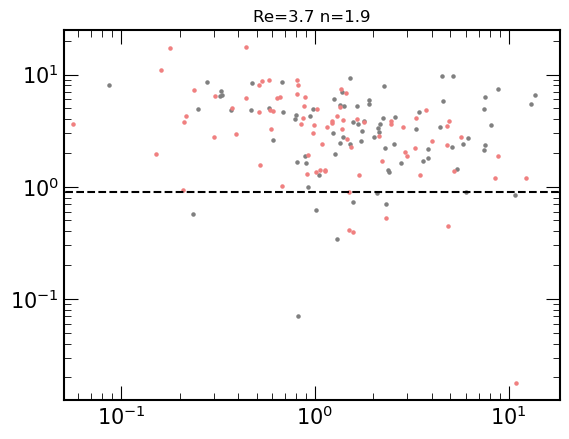

In [3]:
#NFW

n_values = [1.9]
R_e_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'ZoomNFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('ZoomNFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
                      